# Summary Notebook for results

## Libraries Section

In [1]:
#Handing data 
import pandas as pd
import numpy as np
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('paper')
#Pymoo multi-objective optimization 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population
#Finance libraries 
import yfinance as yf
import yesg
#Plugins
from tqdm import tqdm #Timing iteration
#from itertools import compress 
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras
from Plugins import DS
from Plugins import evaluation
from Plugins import random_portfolios
from Plugins import cd_diagram
#Finance libraries 
from finquant import efficient_frontier

## General Configuration

In [2]:
eps = np.array([0.01,0.01])
#colors = ['#f0f2fa','#8da0cb', '#1b9e77']
colors =sns.color_palette("viridis", n_colors=2).as_hex()
colors

['#31688e', '#35b779']

In [3]:
#Algoritmos Evolutivos
from pymoo.termination import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
termination = get_termination("n_gen", 250)
nsgaii = NSGA2(pop_size=100,repair=pymoo_extras.Portfolio_Repair())
sms = SMSEMOA(pop_size=100, repair=pymoo_extras.Portfolio_Repair())

## Random  Example

In [4]:
## NUMBER OF ASSETS
n_assets = 4 #Assets
n_portfolios=25000
seed, returns, assets_info = random_portfolios.random_returns(n_assets=4)
assets_info.head()
#seed =8082

The seed was:  3043


,exp_risk,exp_return,esg_score
s1,0.152490,-0.079643,0.667648
s2,0.161160,-0.125158,0.774942
s3,0.158755,-0.153462,0.188818
s4,0.161885,-0.094700,0.584688


In [4]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns, assets_info)
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES) #Negative return (for minimize)

In [5]:
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
min_vol_weights = ef.minimum_volatility(save_weights=False)
min_return = -portfolio_problem.evaluate(min_vol_weights)[1]*252 #Positive return (for maximize)
max_return = np.max(PROFITS)*252
targets = np.linspace(round(min_return, 8), round(max_return, 8), 100)
ef_R = ef.efficient_frontier(targets=targets)

In [6]:
X_dummy = random_portfolios.rand_weights(n_portfolios,n_assets)
F_dummy, ESG_dummy =pymoo_extras.eval_weights(portfolio_problem, X_dummy)
FA_dummy =  pymoo_extras.annualised_portfolio_quantities(F_dummy)
FA_dummy_best_eps = ArchievingStrategies.get_best_opt_eps(FA_dummy, 1e-6, eps)
FA_dummy_best = ArchievingStrategies.get_best_opt(FA_dummy_best_eps, 1e-6)
FA_3D = FA_dummy_best_eps.copy()
FA_3D['exp_esg'] = ESG_dummy[FA_dummy_best_eps.index]
FA_3D_best       = ArchievingStrategies.get_best_opt(FA_3D, 1e-6)
print('Total', FA_dummy.shape)
print('Eps-Mejores', FA_dummy_best_eps.shape)
print('Mejores', FA_dummy_best.shape)
print('Mejores 3D', FA_3D_best.shape)

25000it [00:32, 777.83it/s] 
19077it [00:00, 24330.65it/s]
19077it [00:01, 11898.79it/s]

Total (25000, 2)
Eps-Mejores (19077, 2)
Mejores (266, 2)
Mejores 3D (1539, 3)


Text(0.5, -0.75, 'b) Optimal Portfolios for 3 objectives problem')

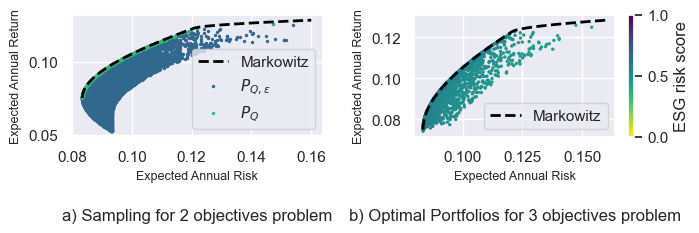

In [7]:
frames = [FA_dummy_best_eps, FA_dummy_best]
labels = [r'$P_{Q,\epsilon}$', '$P_{Q}$']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.3), tight_layout=True)
ax[0] =my_plotting.plotting_samples_with_ax(ef_R, frames, labels,colors, ax[0])
ax[0].set_title('a) Sampling for 2 objectives problem', y=-0.75 )
ax[1] = my_plotting.plotting_projection_with_ax(FA_3D_best, ef_R, colormap='viridis_r', vmin=0.0, vmax=1.0, ax=ax[1])
ax[1].set_title('b) Optimal Portfolios for 3 objectives problem', y=-0.75)

## Non Dominated Assets 

In [58]:
#DowJones
dowjones_assets_info = pd.read_csv('data/AssetsInfo/full_dowjones.csv', index_col=0)
dowjones_best_assets = pd.read_csv('data/AssetsInfo/best_dowjones.csv', index_col=0)
dowjones_returns= pd.read_csv('data/Historical/returns_dowjones.csv', index_col=0)
#Nasdaq100 
nasdaq100_assets_info = pd.read_csv('data/AssetsInfo/full_nasdaq100.csv', index_col=0)
nasdaq100_best_assets = pd.read_csv('data/AssetsInfo/best_nasdaq100.csv', index_col=0)
nasdaq100_returns= pd.read_csv('data/Historical/returns_nasdaq100.csv', index_col=0)
#SP500
sp500_assets_info = pd.read_csv('data/AssetsInfo/full_sp500.csv', index_col=0)
sp500_best_assets = pd.read_csv('data/AssetsInfo/best_sp500.csv', index_col=0)
sp500_returns= pd.read_csv('data/Historical/returns_sp500.csv', index_col=0)

Text(0.5, -0.55, 'c) S&P500')

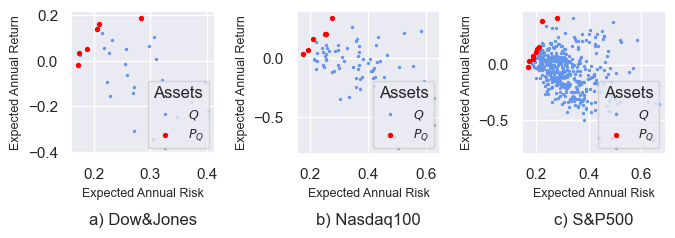

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.3), tight_layout=True)
ax[0]= my_plotting.plot_assets_with_ax(dowjones_assets_info, dowjones_best_assets, ax=ax[0])
ax[0].set_title('a) Dow&Jones', y=-0.55)
ax[1]= my_plotting.plot_assets_with_ax(nasdaq100_assets_info, nasdaq100_best_assets, ax=ax[1])
ax[1].set_title('b) Nasdaq100', y=-0.55)
ax[2]= my_plotting.plot_assets_with_ax(sp500_assets_info, sp500_best_assets, ax=ax[2])
ax[2].set_title('c) S&P500', y=-0.55)

## Samplings for DowJones

In [11]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(dowjones_returns[dowjones_best_assets.index],
                                                            dowjones_assets_info.loc[dowjones_best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES) #Negative return (for minimize)
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
min_vol_weights = ef.minimum_volatility(save_weights=False)
min_return = -portfolio_problem.evaluate(min_vol_weights)[1]*252 #Positive return (for maximize)
max_return = np.max(PROFITS)*252
targets = np.linspace(round(min_return, 8), round(max_return, 8), 100)
ef_R = ef.efficient_frontier(targets=targets)

In [12]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=17)
F_das, ESG_das =pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das_best_eps, 1e-6)

print('Total', FA_das.shape)
print('Eps-Mejores', FA_das_best_eps.shape)
print('Mejores', FA_das_best.shape)

26334it [00:20, 1279.46it/s]
13307it [00:00, 30321.85it/s]

Total (26334, 2)
Eps-Mejores (13307, 2)
Mejores (97, 2)


In [15]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii_best_eps, 1e-6)

print('Total', FA_nsgaii.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)
print('Mejores', FA_nsgaii_best.shape)

25000it [00:46, 541.51it/s]
22676it [00:03, 7358.69it/s]

Total (25000, 2)
Eps-Mejores (22676, 2)
Mejores (3035, 2)


In [18]:
X_sms, F_sms, ESG_sms =pymoo_extras.get_weights_with_pymoo(portfolio_problem, sms, termination)
FA_sms =  pymoo_extras.annualised_portfolio_quantities(F_sms)
FA_sms_best_eps = ArchievingStrategies.get_best_opt_eps(FA_sms, 1e-6, eps)
FA_sms_best = ArchievingStrategies.get_best_opt(FA_sms_best_eps, 1e-6)

print('Total', FA_sms.shape)
print('Eps-Mejores', FA_sms_best_eps.shape)
print('Mejores', FA_sms_best.shape)

25000it [00:57, 431.26it/s]
24008it [00:04, 5942.04it/s]

Total (25000, 2)
Eps-Mejores (24008, 2)
Mejores (3892, 2)


In [19]:
X_mkds = DS.get_Markowitz_directions(ef, PROFITS, RISK, min_return, max_return, eps, size=500, steps=50)
F_mkds, ESG_mkds = pymoo_extras.eval_weights(portfolio_problem, X_mkds)
FA_mkds =  pymoo_extras.annualised_portfolio_quantities(F_mkds)
FA_mkds_best_eps = ArchievingStrategies.get_best_opt_eps(FA_mkds, 1e-6, eps)
FA_mkds_best = ArchievingStrategies.get_best_opt(FA_mkds_best_eps, 1e-6)

print('Total', FA_mkds.shape)
print('Mejores', FA_mkds_best.shape)
print('Eps-Mejores', FA_mkds_best_eps.shape)

25000it [01:00, 409.88it/s]
24733it [00:01, 12728.35it/s]

Total (25000, 2)
Mejores (1638, 2)
Eps-Mejores (24733, 2)


Text(0.5, -0.55, 'd) SMS-EMOA Sampling')

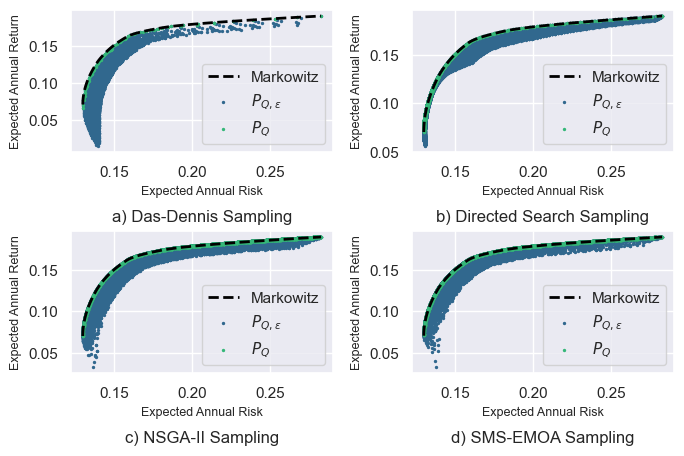

In [33]:
DAS_frames = [FA_das_best_eps, FA_das_best]
SMSEMOA_frames = [FA_sms_best_eps, FA_sms_best]
NSGA2_frames = [FA_nsgaii_best_eps, FA_nsgaii_best]
MKDS_frames = [FA_mkds_best_eps, FA_mkds_best]
labels = [r'$P_{Q,\epsilon}$', '$P_{Q}$']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 4.6), tight_layout=True)
ax[0][0] =my_plotting.plotting_samples_with_ax(ef_R, DAS_frames, labels,colors, ax[0][0])
ax[0][0].set_title('a) Das-Dennis Sampling', y=-0.55 )
ax[0][1] =my_plotting.plotting_samples_with_ax(ef_R, MKDS_frames, labels,colors, ax[0][1])
ax[0][1].set_title('b) Directed Search Sampling', y=-0.55 )
ax[1][0] =my_plotting.plotting_samples_with_ax(ef_R, NSGA2_frames, labels,colors, ax[1][0])
ax[1][0].set_title('c) NSGA-II Sampling', y=-0.55 )
ax[1][1] =my_plotting.plotting_samples_with_ax(ef_R, SMSEMOA_frames, labels,colors, ax[1][1])
ax[1][1].set_title('d) SMS-EMOA Sampling', y=-0.55 )

## Samplings for Nasdaq100

In [34]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(nasdaq100_returns[nasdaq100_best_assets.index],
                                                            nasdaq100_assets_info.loc[nasdaq100_best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES) #Negative return (for minimize)
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
min_vol_weights = ef.minimum_volatility(save_weights=False)
min_return = -portfolio_problem.evaluate(min_vol_weights)[1]*252 #Positive return (for maximize)
max_return = np.max(PROFITS)*252
targets = np.linspace(round(min_return, 8), round(max_return, 8), 100)
ef_R = ef.efficient_frontier(targets=targets)

In [35]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=17)
F_das, ESG_das =pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das_best_eps, 1e-6)

print('Total', FA_das.shape)
print('Eps-Mejores', FA_das_best_eps.shape)
print('Mejores', FA_das_best.shape)

26334it [00:28, 933.78it/s] 
14356it [00:00, 25942.23it/s]

Total (26334, 2)
Eps-Mejores (14356, 2)
Mejores (154, 2)


In [36]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii_best_eps, 1e-6)

print('Total', FA_nsgaii.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)
print('Mejores', FA_nsgaii_best.shape)

25000it [01:01, 407.18it/s]
24389it [00:02, 8940.83it/s] 

Total (25000, 2)
Eps-Mejores (24389, 2)
Mejores (2037, 2)


In [37]:
X_sms, F_sms, ESG_sms =pymoo_extras.get_weights_with_pymoo(portfolio_problem, sms, termination)
FA_sms =  pymoo_extras.annualised_portfolio_quantities(F_sms)
FA_sms_best_eps = ArchievingStrategies.get_best_opt_eps(FA_sms, 1e-6, eps)
FA_sms_best = ArchievingStrategies.get_best_opt(FA_sms_best_eps, 1e-6)

print('Total', FA_sms.shape)
print('Eps-Mejores', FA_sms_best_eps.shape)
print('Mejores', FA_sms_best.shape)

25000it [01:01, 407.28it/s]
24716it [00:05, 4610.83it/s]

Total (25000, 2)
Eps-Mejores (24716, 2)
Mejores (4047, 2)


In [38]:
X_mkds = DS.get_Markowitz_directions(ef, PROFITS, RISK, min_return, max_return, eps, size=500, steps=50)
F_mkds, ESG_mkds = pymoo_extras.eval_weights(portfolio_problem, X_mkds)
FA_mkds =  pymoo_extras.annualised_portfolio_quantities(F_mkds)
FA_mkds_best_eps = ArchievingStrategies.get_best_opt_eps(FA_mkds, 1e-6, eps)
FA_mkds_best = ArchievingStrategies.get_best_opt(FA_mkds_best_eps, 1e-6)

print('Total', FA_mkds.shape)
print('Mejores', FA_mkds_best.shape)
print('Eps-Mejores', FA_mkds_best_eps.shape)

25000it [00:50, 494.68it/s]
24869it [00:03, 7713.73it/s]

Total (25000, 2)
Mejores (2716, 2)
Eps-Mejores (24869, 2)


Text(0.5, -0.55, 'd) SMS-EMOA Sampling')

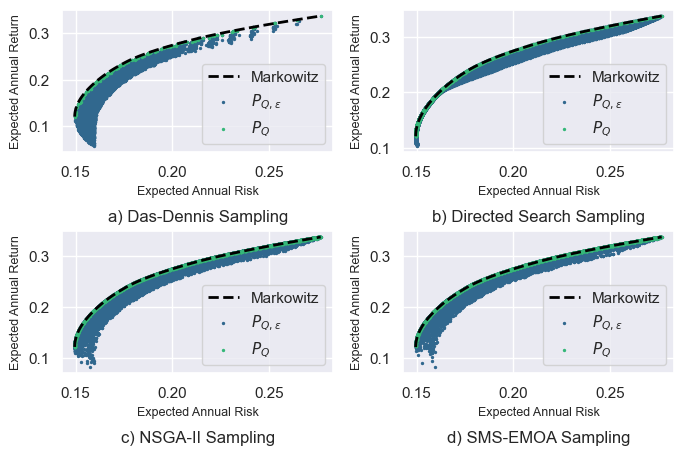

In [39]:
DAS_frames = [FA_das_best_eps, FA_das_best]
SMSEMOA_frames = [FA_sms_best_eps, FA_sms_best]
NSGA2_frames = [FA_nsgaii_best_eps, FA_nsgaii_best]
MKDS_frames = [FA_mkds_best_eps, FA_mkds_best]
labels = [r'$P_{Q,\epsilon}$', '$P_{Q}$']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 4.6), tight_layout=True)
ax[0][0] =my_plotting.plotting_samples_with_ax(ef_R, DAS_frames, labels,colors, ax[0][0])
ax[0][0].set_title('a) Das-Dennis Sampling', y=-0.55 )
ax[0][1] =my_plotting.plotting_samples_with_ax(ef_R, MKDS_frames, labels,colors, ax[0][1])
ax[0][1].set_title('b) Directed Search Sampling', y=-0.55 )
ax[1][0] =my_plotting.plotting_samples_with_ax(ef_R, NSGA2_frames, labels,colors, ax[1][0])
ax[1][0].set_title('c) NSGA-II Sampling', y=-0.55 )
ax[1][1] =my_plotting.plotting_samples_with_ax(ef_R, SMSEMOA_frames, labels,colors, ax[1][1])
ax[1][1].set_title('d) SMS-EMOA Sampling', y=-0.55 )

## Samplings for SP500

In [40]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(sp500_returns[sp500_best_assets.index],
                                                            sp500_assets_info.loc[sp500_best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES) #Negative return (for minimize)
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
min_vol_weights = ef.minimum_volatility(save_weights=False)
min_return = -portfolio_problem.evaluate(min_vol_weights)[1]*252 #Positive return (for maximize)
max_return = np.max(PROFITS)*252
targets = np.linspace(round(min_return, 8), round(max_return, 8), 100)
ef_R = ef.efficient_frontier(targets=targets)

In [42]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=9)
F_das, ESG_das =pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das_best_eps, 1e-6)

print('Total', FA_das.shape)
print('Eps-Mejores', FA_das_best_eps.shape)
print('Mejores', FA_das_best.shape)

24310it [00:15, 1537.82it/s]
11045it [00:00, 31036.93it/s]

Total (24310, 2)
Eps-Mejores (11045, 2)
Mejores (84, 2)


In [43]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii_best_eps, 1e-6)

print('Total', FA_nsgaii.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)
print('Mejores', FA_nsgaii_best.shape)

25000it [00:51, 489.28it/s]
22850it [00:02, 9809.96it/s] 

Total (25000, 2)
Eps-Mejores (22850, 2)
Mejores (2060, 2)


In [44]:
X_sms, F_sms, ESG_sms =pymoo_extras.get_weights_with_pymoo(portfolio_problem, sms, termination)
FA_sms =  pymoo_extras.annualised_portfolio_quantities(F_sms)
FA_sms_best_eps = ArchievingStrategies.get_best_opt_eps(FA_sms, 1e-6, eps)
FA_sms_best = ArchievingStrategies.get_best_opt(FA_sms_best_eps, 1e-6)

print('Total', FA_sms.shape)
print('Eps-Mejores', FA_sms_best_eps.shape)
print('Mejores', FA_sms_best.shape)

25000it [00:53, 466.56it/s]
24802it [00:03, 7330.34it/s] 

Total (25000, 2)
Eps-Mejores (24802, 2)
Mejores (2397, 2)


In [45]:
X_mkds = DS.get_Markowitz_directions(ef, PROFITS, RISK, min_return, max_return, eps, size=500, steps=50)
F_mkds, ESG_mkds = pymoo_extras.eval_weights(portfolio_problem, X_mkds)
FA_mkds =  pymoo_extras.annualised_portfolio_quantities(F_mkds)
FA_mkds_best_eps = ArchievingStrategies.get_best_opt_eps(FA_mkds, 1e-6, eps)
FA_mkds_best = ArchievingStrategies.get_best_opt(FA_mkds_best_eps, 1e-6)

print('Total', FA_mkds.shape)
print('Mejores', FA_mkds_best.shape)
print('Eps-Mejores', FA_mkds_best_eps.shape)

25000it [01:14, 337.64it/s]
24260it [00:05, 4577.67it/s]

Total (25000, 2)
Mejores (3544, 2)
Eps-Mejores (24260, 2)


Text(0.5, -0.55, 'd) SMS-EMOA Sampling')

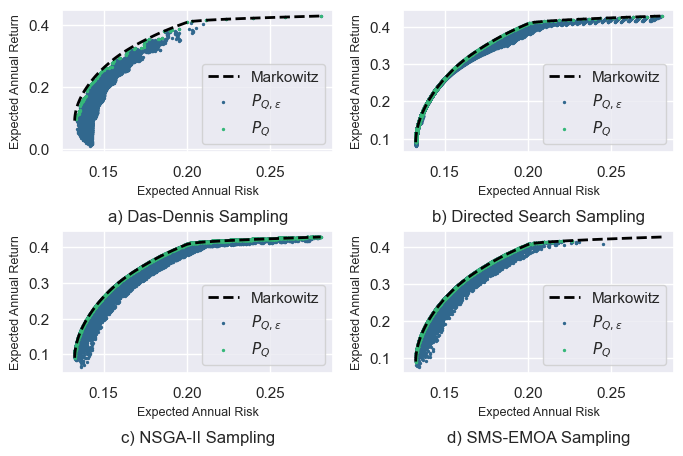

In [46]:
DAS_frames = [FA_das_best_eps, FA_das_best]
SMSEMOA_frames = [FA_sms_best_eps, FA_sms_best]
NSGA2_frames = [FA_nsgaii_best_eps, FA_nsgaii_best]
MKDS_frames = [FA_mkds_best_eps, FA_mkds_best]
labels = [r'$P_{Q,\epsilon}$', '$P_{Q}$']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 4.6), tight_layout=True)
ax[0][0] =my_plotting.plotting_samples_with_ax(ef_R, DAS_frames, labels,colors, ax[0][0])
ax[0][0].set_title('a) Das-Dennis Sampling', y=-0.55 )
ax[0][1] =my_plotting.plotting_samples_with_ax(ef_R, MKDS_frames, labels,colors, ax[0][1])
ax[0][1].set_title('b) Directed Search Sampling', y=-0.55 )
ax[1][0] =my_plotting.plotting_samples_with_ax(ef_R, NSGA2_frames, labels,colors, ax[1][0])
ax[1][0].set_title('c) NSGA-II Sampling', y=-0.55 )
ax[1][1] =my_plotting.plotting_samples_with_ax(ef_R, SMSEMOA_frames, labels,colors, ax[1][1])
ax[1][1].set_title('d) SMS-EMOA Sampling', y=-0.55 )

## Evaluations

In [5]:
report0 = pd.read_csv('FinalResults/sp500.csv')
report1 = pd.read_csv('FinalResults/dowjones.csv')
report2 = pd.read_csv('FinalResults/nasdaq100.csv')
reports = pd.concat([report0, report1, report2])

In [6]:
reports.columns

Index(['BursatilIndex', 'Sampling Method', 'Indicator', 'Execution',
       'Ind_Value'],
      dtype='object')

In [7]:
reports.columns
reports_groups =reports.groupby(['BursatilIndex', 'Sampling Method', 'Indicator'], as_index=False).agg({'Ind_Value': ['mean', 'std']})
#reports_final = pd.pivot(reports_groups, index = ['BursatilIndex', 'Sampling Method'], columns='Indicator')

#reports_final = pd.pivot(reports_groups,index=reports_groups.index, columns=reports_groups.columns, values='Ind_Value')
#final_results = pd.pivot_table(reports_groups, index=['BursatilIndex', 'Sampling Method'], columns='Indicator').reset_index()
#final_results
#reports_final.columns
reports_groups.columns = list(map(lambda x: '_'.join(x).rstrip('_'), reports_groups.columns)) 
reports_groups['Ind_Value_mean'] = reports_groups['Ind_Value_mean'].apply(lambda x: "{:.6f}".format(x))
reports_groups['Ind_Value_std'] = reports_groups['Ind_Value_std'].apply(lambda x: "({:.8f}))".format(x))
reports_groups['Format_Value']  = reports_groups['Ind_Value_mean']+' '+reports_groups['Ind_Value_std']
reports_final = pd.pivot_table(reports_groups, index=['BursatilIndex', 'Sampling Method'], columns='Indicator', values='Format_Value', 
                               aggfunc=','.join)
reports_final.reset_index()

Indicator,BursatilIndex,Sampling Method,GD,GDplus,HV,IGD,IGDplus
0,dowjones,das,0.009862 (0.00000000)),0.009859 (0.00000000)),1.101261 (0.00000000)),0.000892 (0.00000000)),0.000566 (0.00000000))
1,dowjones,mkds,0.001989 (0.00000000)),0.001835 (0.00000000)),1.107397 (0.00000000)),0.000080 (0.00000000)),0.000040 (0.00000000))
2,dowjones,nsgaii,0.002574 (0.00007422)),0.002264 (0.00005940)),1.107681 (0.00002490)),0.000068 (0.00000551)),0.000053 (0.00000520))
3,dowjones,sms,0.002082 (0.00012400)),0.001859 (0.00009062)),1.107742 (0.00036524)),0.000047 (0.00003871)),0.000023 (0.00000561))
4,nasdaq100,das,0.009138 (0.00000000)),0.009133 (0.00000000)),0.979601 (0.00000000)),0.001259 (0.00000000)),0.001046 (0.00000000))
5,nasdaq100,mkds,0.002831 (0.00000000)),0.002651 (0.00000000)),0.991440 (0.00000000)),0.000085 (0.00000000)),0.000059 (0.00000000))
6,nasdaq100,nsgaii,0.002420 (0.00003775)),0.002332 (0.00003928)),0.991479 (0.00003289)),0.000089 (0.00000547)),0.000073 (0.00000492))
7,nasdaq100,sms,0.001976 (0.00006546)),0.001855 (0.00006726)),0.991793 (0.00006992)),0.000046 (0.00000534)),0.000030 (0.00000271))
8,sp500,das,0.011090 (0.00000000)),0.011075 (0.00000000)),1.052160 (0.00000000)),0.002590 (0.00000000)),0.002182 (0.00000000))
9,sp500,mkds,0.001637 (0.00000000)),0.001177 (0.00000000)),1.069357 (0.00000000)),0.000083 (0.00000000)),0.000052 (0.00000000))


In [8]:
with open('final_results.tex','w') as tf:
    tf.write(reports_final.reset_index().to_latex(index=False, index_names=False))

## Critical Difference

In [9]:
reports

,BursatilIndex,Sampling Method,Indicator,Execution,Ind_Value
0,sp500,das,GD,0,0.01109
1,sp500,das,GD,1,0.01109
2,sp500,das,GD,2,0.01109
3,sp500,das,GD,3,0.01109
4,sp500,das,GD,4,0.01109
...,...,...,...,...,...
395,nasdaq100,mkds,HV,15,0.99144
396,nasdaq100,mkds,HV,16,0.99144
397,nasdaq100,mkds,HV,17,0.99144
398,nasdaq100,mkds,HV,18,0.99144


C:\Users\yeudi\AppData\Local\Temp\ipykernel_3620\3810365401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports_case['Sampling Method'] =reports_case['Sampling Method'].replace({'das': 'Das-Dennis',
C:\Users\yeudi\AppData\Local\Temp\ipykernel_3620\3810365401.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports_case['BursatilIndex'] = reports_case['BursatilIndex']+'_'+reports_case['Execution'].astype(str)


['Das-Dennis' 'NSGA-II' 'SMS-EMOA' 'Directed Search']
Das-Dennis          0.0
Directed Search    20.0
NSGA-II             1.0
SMS-EMOA           39.0
dtype: float64
Das-Dennis         3.983333
Directed Search    2.300000
NSGA-II            2.016667
SMS-EMOA           1.700000
dtype: float64
('Das-Dennis', 'Directed Search', 8.56361658082565e-12, True)
('Das-Dennis', 'NSGA-II', 1.6295557943119345e-11, True)
('Das-Dennis', 'SMS-EMOA', 1.7141493981716166e-11, True)
('NSGA-II', 'Directed Search', 0.08629876003307035, False)
('SMS-EMOA', 'Directed Search', 0.4751805002284377, False)
('NSGA-II', 'SMS-EMOA', 0.48433189914902974, False)
Index(['Das-Dennis', 'Directed Search', 'NSGA-II', 'SMS-EMOA'], dtype='object')
[1, 2, 3]


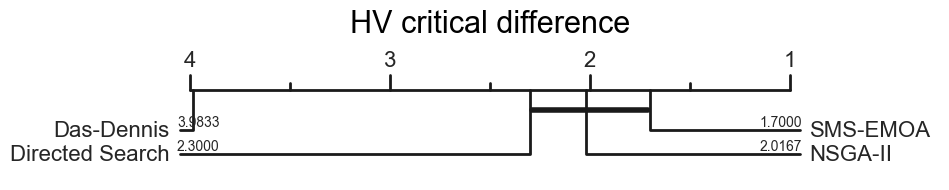

In [43]:
#Critial Difference para HV 
reports_case = reports[reports['Indicator']=='HV']
reports_case['Sampling Method'] =reports_case['Sampling Method'].replace({'das': 'Das-Dennis', 
                                                                          'mkds': 'Directed Search', 
                                                                          'nsgaii': 'NSGA-II', 
                                                                          'sms': 'SMS-EMOA'})
reports_case['BursatilIndex'] = reports_case['BursatilIndex']+'_'+reports_case['Execution'].astype(str)
reports_case = reports_case.reset_index(drop=True)[['Sampling Method', 'BursatilIndex', 'Ind_Value']]
reports_case
#reports_summary = reports[reports['Indicator']=='HV'].groupby(['Sampling Method', 'BursatilIndex'], as_index=False).agg({'Ind_Value': 'mean'})
#reports_summary
cd_diagram.draw_cd_diagram(df_perf=reports_case[['Sampling Method', 'BursatilIndex', 'Ind_Value']], title='HV critical difference', labels=True)

C:\Users\yeudi\AppData\Local\Temp\ipykernel_3620\3022129941.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports_case['Ind_Value'][reports_case['Indicator']=='HV'] = -reports_case['Ind_Value'][reports_case['Indicator']=='HV']
C:\Users\yeudi\AppData\Local\Temp\ipykernel_3620\3022129941.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports_case['Ind_Value'][reports_case['Indicator']=='HV'] = -reports_case['Ind_Value'][reports_case['Indicator']=='HV']


['Das-Dennis' 'NSGA-II' 'SMS-EMOA' 'Directed Search']
Das-Dennis         299.0
Directed Search      0.0
NSGA-II              0.0
SMS-EMOA             1.0
dtype: float64
SMS-EMOA           3.386667
Directed Search    3.090000
NSGA-II            2.520000
Das-Dennis         1.003333
dtype: float64
('Das-Dennis', 'Directed Search', 5.368953393267029e-51, True)
('Das-Dennis', 'NSGA-II', 6.083559849691438e-51, True)
('Das-Dennis', 'SMS-EMOA', 6.144866877758197e-51, True)
('NSGA-II', 'SMS-EMOA', 9.333368096111825e-18, True)
('NSGA-II', 'Directed Search', 1.643315338179343e-08, True)
('SMS-EMOA', 'Directed Search', 0.9952246579170478, False)
Index(['SMS-EMOA', 'Directed Search', 'NSGA-II', 'Das-Dennis'], dtype='object')
[0, 1]


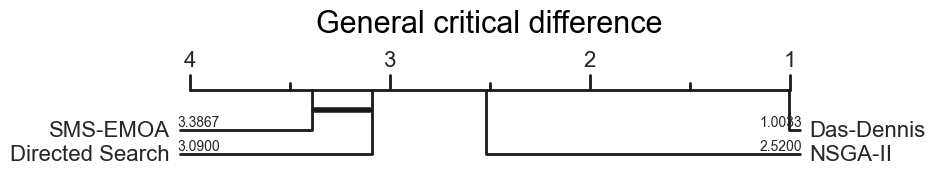

In [56]:
#Critial Difference para HV 
reports_case = reports.copy()
reports_case['Sampling Method'] =reports_case['Sampling Method'].replace({'das': 'Das-Dennis', 
                                                                          'mkds': 'Directed Search', 
                                                                          'nsgaii': 'NSGA-II', 
                                                                          'sms': 'SMS-EMOA'})
reports_case['Ind_Value'][reports_case['Indicator']=='HV'] = -reports_case['Ind_Value'][reports_case['Indicator']=='HV']
reports_case['BursatilIndex'] = reports_case['BursatilIndex']+'_'+reports_case['Indicator']+'_'+reports_case['Execution'].astype(str)
reports_case = reports_case.reset_index(drop=True)[['Sampling Method', 'BursatilIndex', 'Ind_Value']]
reports_case
cd_diagram.draw_cd_diagram(df_perf=reports_case[['Sampling Method', 'BursatilIndex', 'Ind_Value']], title='General critical difference', labels=True)

## Best Results 3D

In [64]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(dowjones_returns[dowjones_best_assets.index],
                                                            dowjones_assets_info.loc[dowjones_best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES) #Negative return (for minimize)
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
min_vol_weights = ef.minimum_volatility(save_weights=False)
min_return = -portfolio_problem.evaluate(min_vol_weights)[1]*252 #Positive return (for maximize)
max_return = np.max(PROFITS)*252
targets = np.linspace(round(min_return, 8), round(max_return, 8), 100)
ef_R_dowjones = ef.efficient_frontier(targets=targets)
X_sms, F_sms, ESG_sms =pymoo_extras.get_weights_with_pymoo(portfolio_problem, sms, termination)
FA_sms =  pymoo_extras.annualised_portfolio_quantities(F_sms)
FA_sms_best_eps = ArchievingStrategies.get_best_opt_eps(FA_sms, 1e-6, eps)
FA_sms_best = ArchievingStrategies.get_best_opt(FA_sms_best_eps, 1e-6)
FA_3D_sms = FA_sms_best_eps.copy()
FA_3D_sms['exp_esg'] = ESG_sms[FA_sms_best_eps.index]
FA_3D_best_dowjones       = ArchievingStrategies.get_best_opt(FA_3D_sms, 1e-6)
print('Total', FA_sms.shape)
print('Eps-Mejores', FA_sms_best_eps.shape)
print('Mejores', FA_sms_best.shape)
print('Mejores 3D', FA_3D_best_dowjones.shape)

25000it [01:16, 328.43it/s]
24113it [00:05, 4420.71it/s]
24113it [00:10, 2296.37it/s]

Total (25000, 2)
Eps-Mejores (24113, 2)
Mejores (3823, 2)
Mejores 3D (6521, 3)


In [65]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(nasdaq100_returns[nasdaq100_best_assets.index],
                                                            nasdaq100_assets_info.loc[nasdaq100_best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES) #Negative return (for minimize)
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
min_vol_weights = ef.minimum_volatility(save_weights=False)
min_return = -portfolio_problem.evaluate(min_vol_weights)[1]*252 #Positive return (for maximize)
max_return = np.max(PROFITS)*252
targets = np.linspace(round(min_return, 8), round(max_return, 8), 100)
ef_R_nasdaq100 = ef.efficient_frontier(targets=targets)
X_sms, F_sms, ESG_sms =pymoo_extras.get_weights_with_pymoo(portfolio_problem, sms, termination)
FA_sms =  pymoo_extras.annualised_portfolio_quantities(F_sms)
FA_sms_best_eps = ArchievingStrategies.get_best_opt_eps(FA_sms, 1e-6, eps)
FA_sms_best = ArchievingStrategies.get_best_opt(FA_sms_best_eps, 1e-6)
FA_3D_sms = FA_sms_best_eps.copy()
FA_3D_sms['exp_esg'] = ESG_sms[FA_sms_best_eps.index]
FA_3D_best_nasdaq100       = ArchievingStrategies.get_best_opt(FA_3D_sms, 1e-6)
print('Total', FA_sms.shape)
print('Eps-Mejores', FA_sms_best_eps.shape)
print('Mejores', FA_sms_best.shape)
print('Mejores 3D', FA_3D_best_nasdaq100.shape)

25000it [01:12, 342.48it/s]
24710it [00:06, 4022.96it/s]
24710it [00:13, 1859.37it/s]

Total (25000, 2)
Eps-Mejores (24710, 2)
Mejores (3965, 2)
Mejores 3D (7613, 3)


In [60]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(sp500_returns[sp500_best_assets.index],
                                                            sp500_assets_info.loc[sp500_best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES) #Negative return (for minimize)
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
min_vol_weights = ef.minimum_volatility(save_weights=False)
min_return = -portfolio_problem.evaluate(min_vol_weights)[1]*252 #Positive return (for maximize)
max_return = np.max(PROFITS)*252
targets = np.linspace(round(min_return, 8), round(max_return, 8), 100)
ef_R_sp500 = ef.efficient_frontier(targets=targets)
X_sms, F_sms, ESG_sms =pymoo_extras.get_weights_with_pymoo(portfolio_problem, sms, termination)
FA_sms =  pymoo_extras.annualised_portfolio_quantities(F_sms)
FA_sms_best_eps = ArchievingStrategies.get_best_opt_eps(FA_sms, 1e-6, eps)
FA_sms_best = ArchievingStrategies.get_best_opt(FA_sms_best_eps, 1e-6)
FA_3D_sms = FA_sms_best_eps.copy()
FA_3D_sms['exp_esg'] = ESG_sms[FA_sms_best_eps.index]
FA_3D_best_sp500       = ArchievingStrategies.get_best_opt(FA_3D_sms, 1e-6)
print('Total', FA_sms.shape)
print('Eps-Mejores', FA_sms_best_eps.shape)
print('Mejores', FA_sms_best.shape)
print('Mejores 3D', FA_3D_best_sp500.shape)

25000it [01:36, 258.44it/s]
24739it [00:06, 3889.91it/s]
24739it [00:13, 1845.09it/s]

Total (25000, 2)
Eps-Mejores (24739, 2)
Mejores (2388, 2)
Mejores 3D (5784, 3)


Text(0.5, -0.55, 'c) Optimal portfolios in the 3 objectives problem for S&P500')

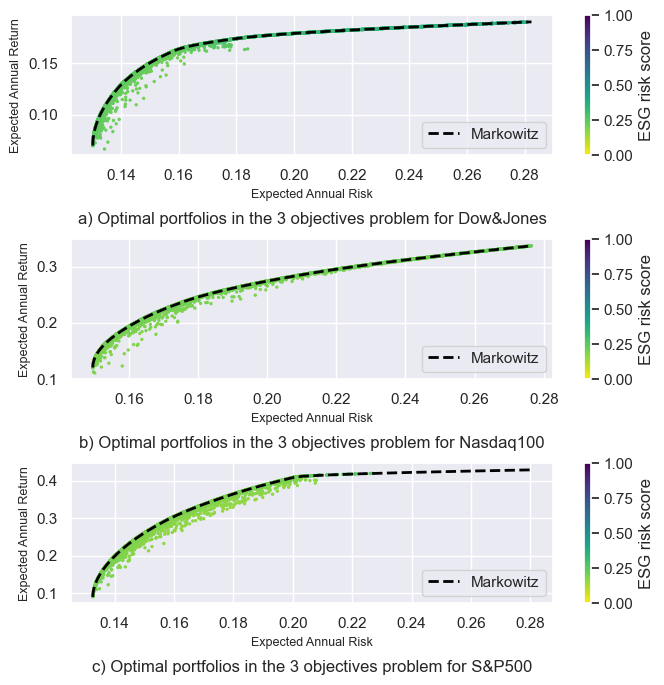

In [67]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7, 6.9), tight_layout=True)
ax[0] =my_plotting.plotting_projection_with_ax(FA_3D_best_dowjones, ef_R_dowjones, colormap='viridis_r', vmin=0.0, vmax=1.0, ax=ax[0])
ax[0].set_title('a) Optimal portfolios in the 3 objectives problem for Dow&Jones', y=-0.55 )
ax[1] =my_plotting.plotting_projection_with_ax(FA_3D_best_nasdaq100, ef_R_nasdaq100, colormap='viridis_r', vmin=0.0, vmax=1.0, ax=ax[1])
ax[1].set_title('b) Optimal portfolios in the 3 objectives problem for Nasdaq100', y=-0.55 )
ax[2] =my_plotting.plotting_projection_with_ax(FA_3D_best_sp500, ef_R_sp500, colormap='viridis_r', vmin=0.0, vmax=1.0, ax=ax[2])
ax[2].set_title('c) Optimal portfolios in the 3 objectives problem for S&P500', y=-0.55 )